This code block imports the "drive" module from the Google Colab library and mounts the Google Drive directory to the Colab runtime environment. This allows users to access and manipulate files stored in their Google Drive account directly from within the Colab environment.






In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Define data_path variable

In [3]:
data_path = "/content/gdrive/MyDrive/Free/3. Text Generation/Automated Image Captioning/"

Import several libraries

In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

This code block reads in a CSV file named "captions.txt" using the pandas library and assigns the resulting DataFrame object to the variable "data". The "head()" method is then called on "data" to display the first few rows of the DataFrame. This code is typically used to explore and verify the contents of the CSV file, such as checking for missing or incorrect data, before using it for further analysis or processing.






In [ ]:
data = pd.read_csv(data_path + "captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


This code block defines two functions for working with image data. The first function, "readImage", takes a file path and an image size as inputs, loads the image file using the "load_img" function from the Keras library, resizes the image to the specified size, converts it to a NumPy array, and scales the pixel values to the range of [0,1]. The function then returns the processed image as a NumPy array.

The second function, "display_images", takes a DataFrame object containing image filenames and captions as inputs, resets the index of the DataFrame, and creates a 5x5 grid of subplots with matplotlib. For each subplot, the function calls "readImage" to load and preprocess the corresponding image, displays the image using matplotlib, and adds the corresponding caption as the subplot title. This function is typically used to visualize a sample of the image data for quality control or exploratory data analysis.

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(data_path + "images/{}".format(temp_df.image[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

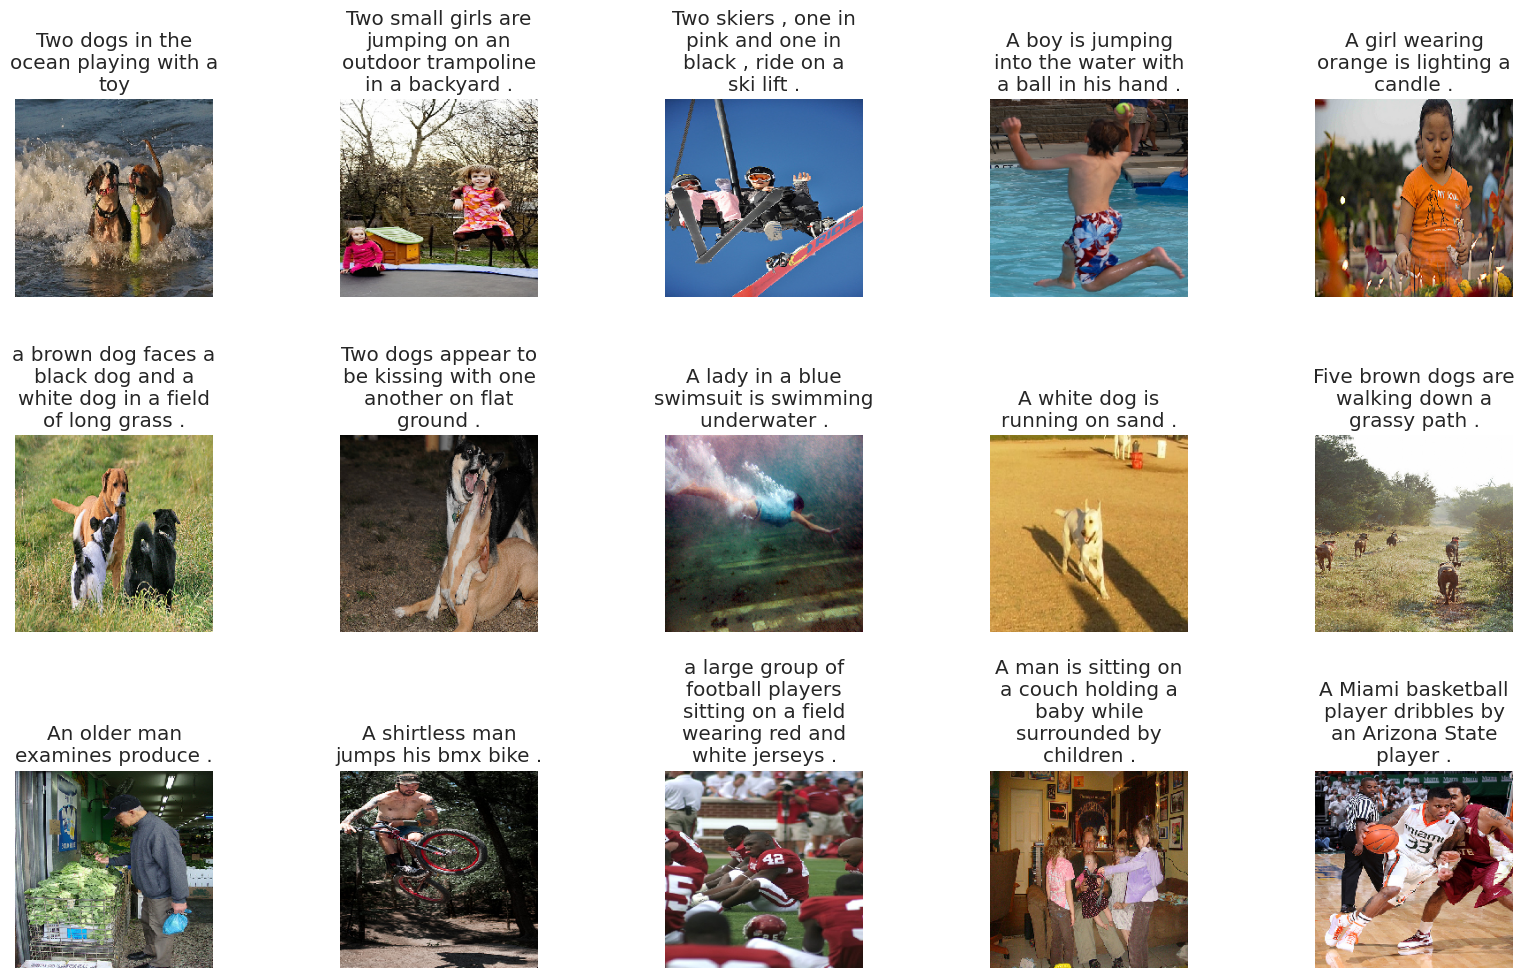

In [ ]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

This code block applies text preprocessing to a DataFrame object called "data" using a function called "text_preprocessing", and then retrieves a list of preprocessed captions from the resulting DataFrame. The "text_preprocessing" function likely applies various text cleaning and normalization techniques, such as converting all text to lowercase, removing punctuation, and lemmatizing or stemming words. The resulting list of preprocessed captions is then assigned to the variable "captions", and the first 10 captions in the list are printed using the "[:10]" indexing syntax. This code is typically used as a preprocessing step for natural language processing tasks, such as training a caption generation model.






In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

This code block defines several variables and performs some data preprocessing steps for a caption generation model.

The "Tokenizer" class from the Keras library is initialized and fitted on the preprocessed caption data stored in the "captions" list. The resulting vocabulary size is stored in the "vocab_size" variable. The maximum length of a caption, in terms of the number of words, is calculated using a generator expression and assigned to the "max_length" variable.

The "images" variable is then created by extracting the unique image filenames from the "data" DataFrame, and the total number of images is stored in "nimages".

The "split_index" variable is calculated as 85% of the total number of images, and the image filenames are split into training and validation sets accordingly. The "train" and "test" DataFrames are then created using boolean indexing based on the image filenames.

Finally, the "texts_to_sequences" method of the tokenizer is used to convert the second caption in the "captions" list from a string of words to a sequence of integers, which represents the corresponding word indices in the tokenizer's word index dictionary. This code is typically used to prepare data for training a neural network model, such as a caption generation model.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

This code block extracts image features using a pre-trained DenseNet201 CNN model, which is instantiated and then modified to output the second to last layer's output. The image features are extracted for each unique image in the data, using a for loop and Keras functions for loading and preprocessing the image data. The features are stored in a dictionary with image filenames as keys, which can be used as input for a machine learning model, such as a caption generation model, in a transfer learning scenario. The code block is designed to enable efficient feature extraction from image data using a pre-trained CNN model.






In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(data_path + "images/", image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 1s 0us/step


 97%|█████████▋| 7832/8091 [43:11<01:23,  3.10it/s]

# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

This code block defines a custom data generator class that generates batches of training data for a machine learning model used for image caption generation. The class inherits from the Keras Sequence class and takes in various parameters including a data frame, image and caption column names, batch size, directory, tokenizer, vocabulary size, and maximum caption length. The class also takes in pre-extracted image features and enables the efficient processing of image and caption data by padding sequences and one-hot encoding target outputs. The CustomDataGenerator class is designed to enable the efficient processing of large datasets for machine learning models that generate captions for images.






In [ ]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

This code block defines a deep learning model for generating captions for images. The model takes two inputs: an image feature vector and a sequence of words representing the caption. The image feature vector is fed through a dense layer and reshaped. The sequence of words is fed through an embedding layer and then concatenated with the reshaped image feature vector. The concatenated output is then fed through a LSTM layer, with a dropout layer for regularization. The LSTM output is then added to the image feature vector before being passed through additional dense and dropout layers to produce the final output, a probability distribution over the vocabulary of possible words in the caption. The model is compiled with the categorical cross-entropy loss function and the Adam optimizer.






In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

Plot the model 

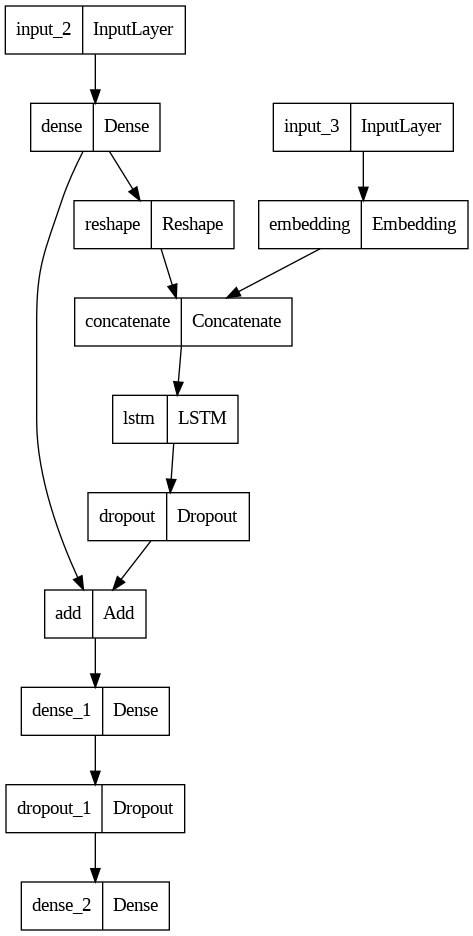

In [ ]:
plot_model(caption_model)

Print the model summary

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

This code block creates two instances of CustomDataGenerator class, train_generator and validation_generator. These instances are used to generate batches of data during model training and validation, by iterating over the image and caption pairs in the train and test data frames. The generators also apply text tokenization and padding, and extract image features using a pre-trained DenseNet201 model.






In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=data_path + "images/",
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=data_path + "images/",
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

This code block creates three callbacks for the Keras model: ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau. These callbacks are used during model training to save the best model based on validation loss, stop training early if the model is not improving, and adjust the learning rate if the validation loss does not improve.






In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

## **Let's train the Model !**

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

This code block trains a neural network model (caption_model) on the training data using the training data generator (train_generator) and validates the model using the validation data generator (validation_generator). The model is trained for 25 epochs, and three callbacks (checkpoint, earlystopping, learning_rate_reduction) are used to save the best model, stop the training if the validation loss does not improve after five epochs, and reduce the learning rate if the validation loss plateaus. The training history is saved to the "history" variable.






In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=25,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/25
537/537 [==============================] - ETA: 0s - loss: 4.8967
Epoch 1: val_loss improved from inf to 4.17516, saving model to model.h5
537/537 [==============================] - 250s 465ms/step - loss: 4.8967 - val_loss: 4.1752 - lr: 0.0010
Epoch 2/25
537/537 [==============================] - ETA: 0s - loss: 4.1408
Epoch 2: val_loss improved from 4.17516 to 3.88537, saving model to model.h5
537/537 [==============================] - 65s 121ms/step - loss: 4.1408 - val_loss: 3.8854 - lr: 0.0010
Epoch 3/25
537/537 [==============================] - ETA: 0s - loss: 3.8987
Epoch 3: val_loss improved from 3.88537 to 3.77523, saving model to model.h5
537/537 [==============================] - 52s 97ms/step - loss: 3.8987 - val_loss: 3.7752 - lr: 0.0010
Epoch 4/25
537/537 [==============================] - ETA: 0s - loss: 3.7436
Epoch 4: val_loss improved from 3.77523 to 3.69629, saving model to model.h5
537/537 [==============================] - 52s 96ms/step - loss: 3.7436 -

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

This code block plots the training and validation loss over the epochs of a neural network model using matplotlib. The figure size is set to 20 by 8, and the loss values are retrieved from the history object returned by the fit() method. The plot includes a title, x and y-axis labels, and a legend that indicates which line represents the training and validation loss. Finally, the plot is displayed using the show() method.






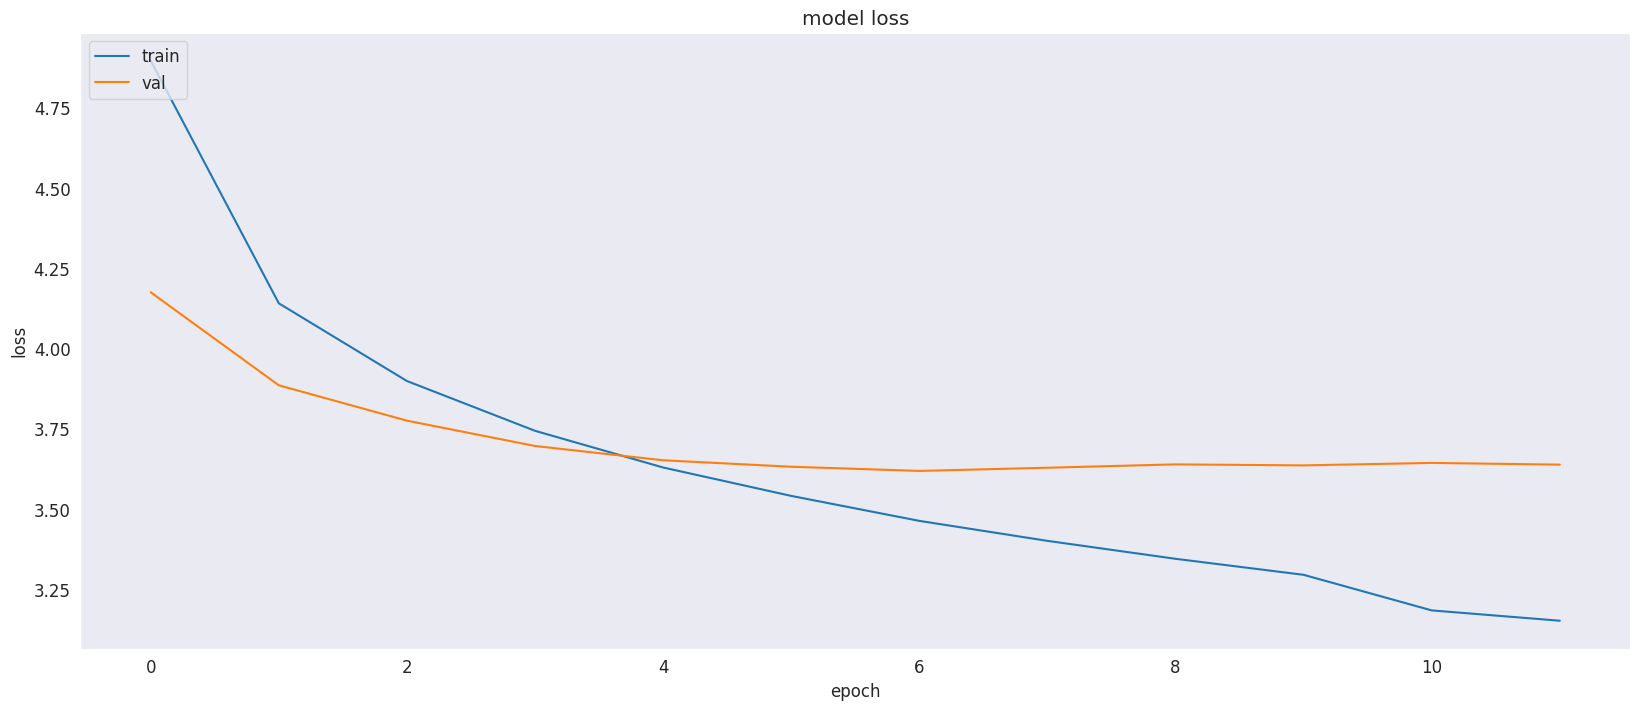

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

The code defines a function named idx_to_word that takes an integer and a tokenizer object as input. It searches the tokenizer's word_index dictionary for the corresponding word to the given integer index and returns the word. If the integer is not found in the dictionary, it returns None.






In [ ]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

The code defines a function named predict_caption that takes in the trained model, an image, a tokenizer, the maximum length of a caption, and the features of the dataset. The function uses the trained model to predict the next word in a caption for the given image. It starts with a token "startseq" and iteratively predicts the next word using the predict() method of the model. The predicted word is added to the sequence until the "endseq" token is predicted or the maximum length of the caption is reached. Finally, the function returns the generated caption.






In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

This code block randomly samples 15 rows from a pandas dataframe called test and resets the index of the resulting dataframe to start from 0.






In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

This code block loads 15 images from a test dataset, resizes them to 224x224 pixels, and predicts a caption for each image using the predict_caption function and the trained caption_model. The predicted captions are stored in the samples DataFrame under the caption column.






In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(data_path + "images/",record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 25ms/step


# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

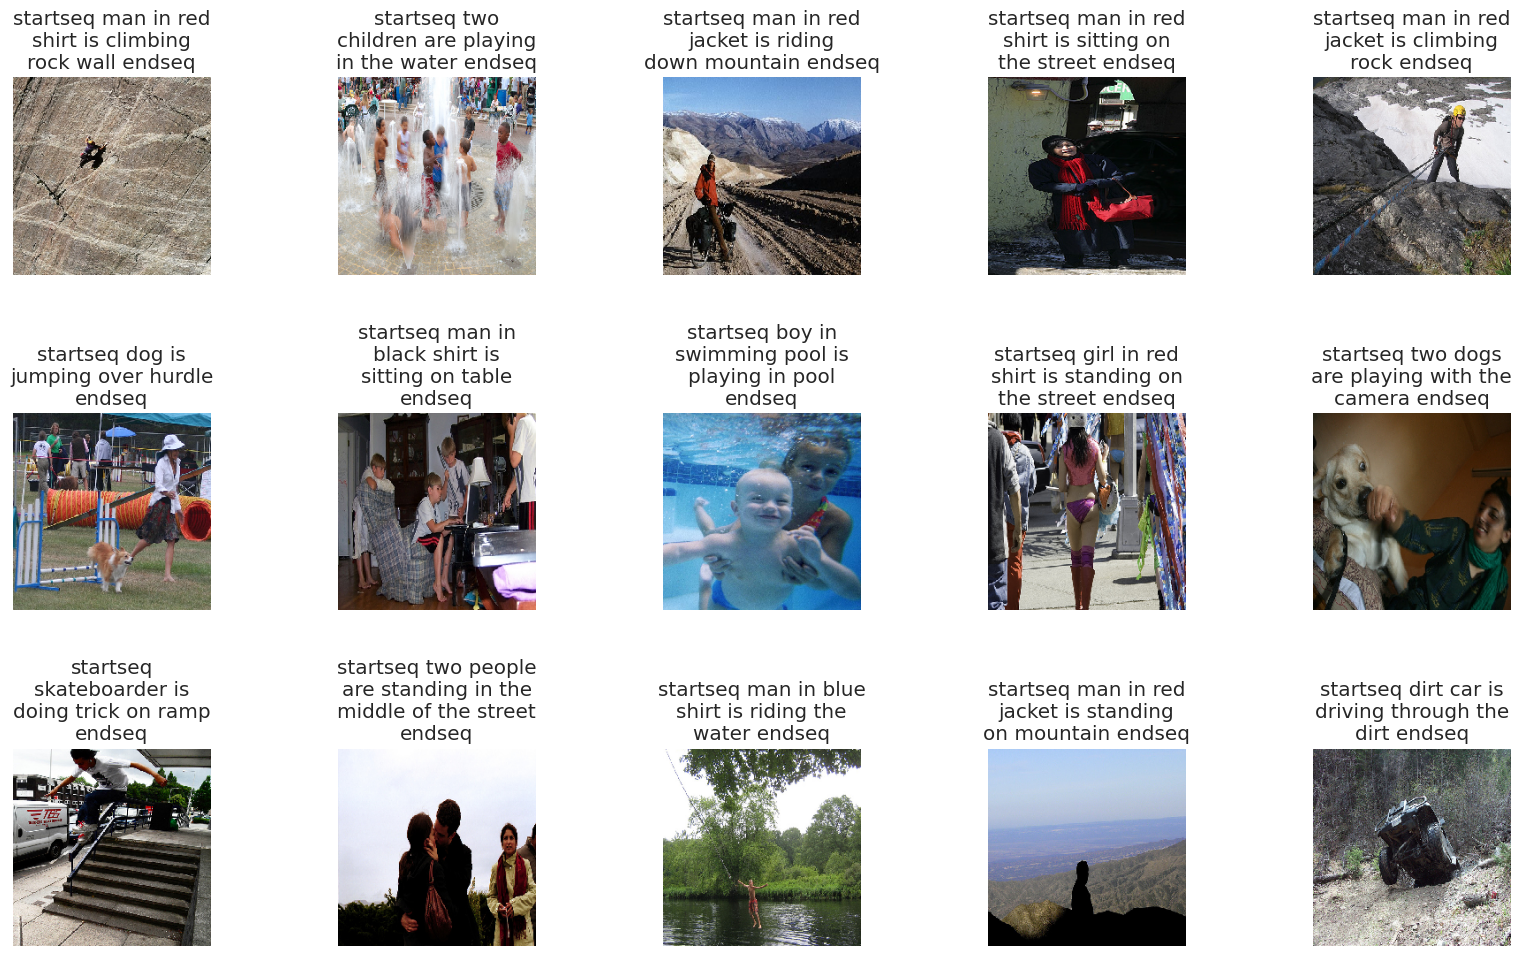

In [ ]:
display_images(samples)

<p style='font-size: 18px'><strong>Conclusion: </strong>This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. 